In [14]:
import numpy as np
import tensorflow as tf
from morphomnist import io, morpho, perturb
import pandas as pd
import pickle
import math
from scipy.stats.distributions import chi2
from scipy.special import erfinv
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(25)
np.random.seed(25)

In [3]:
def erf(x,mu,sig):
    return (1.0 + math.erf((x-mu) / (math.sqrt(2.0)*sig))) / 2.0
    

class negative_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.mse = tf.keras.losses.MeanAbsoluteError()
    def call(self, y_true, y_pred):   
        loss = -1*(self.mse(y_true, y_pred))     
        return loss
      
class pinball_loss(tf.keras.losses.Loss):
    def __init__(self, quantile):
        super().__init__()
        self.tau = quantile
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(self.tau * error, (self.tau - 1) * error), axis=-1)
    
def synthetic_function1(x):
    return np.sin(x)*np.log(np.abs(x)+.01)

def synthetic_function2(x):
    first_term = np.ones(np.shape(x))

    for i in range(100):
        first_term += .5**i*np.cos(10**i*np.pi*x/100)
    return first_term

def load_data_m_mnist():
    images = io.load_idx("Data/Morphomnist/train-images-idx3-ubyte.gz")
    labels = io.load_idx("Data/Morphomnist/train-labels-idx1-ubyte.gz")
    attributes=pd.read_csv("Data/Morphomnist/train-morpho.csv")
    return images/255,labels,pd.DataFrame.to_numpy(attributes)

In [4]:
regression_model_name = "Models/MorphoMnist_Regression_Model"
synthetic_model_name = ["Models/Synthetic_Model_Periodic", "Models/Weierstrass"]

#Load the data
images,label,attributes=load_data_m_mnist()

morpho_train = images[0:int(.9*len(images))]
morpho_test = images[int(.9*len(images)):len(images)]

morpho_train_labels = label[0:int(.9*len(images))]
morpho_test_labels = label[int(.9*len(images)):len(images)]

morpho_train_attributes = attributes[0:int(.9*len(images)),1:]
morpho_test_attributes = attributes[int(.9*len(images)):len(images),1:]

regularization_const = 10**(-1.75)

In [7]:
regularization_const_list_new =np.load("Results/Reg Constants.npy")
list_max_new = np.load("Results/Max list.npy")
list_base_new = np.load("Results/Base list.npy")

Text(0.5, 1.0, 'Regularization Constant vs Max MAE possible')

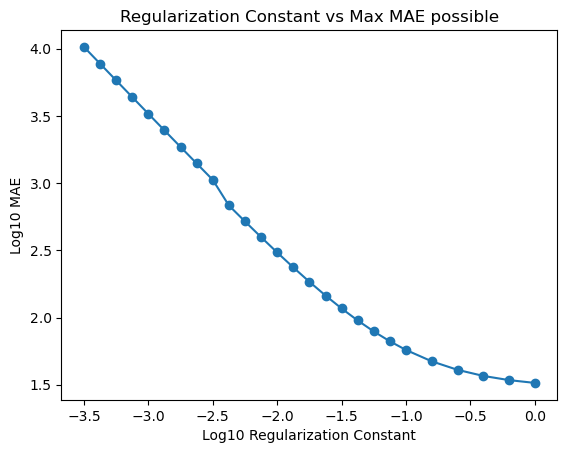

In [9]:
plt.plot(np.log10(regularization_const_list_new), np.log10(list_max_new),'o-')
plt.xlabel("Log10 Regularization Constant")
plt.ylabel("Log10 MAE")
plt.title("Regularization Constant vs Max MAE possible")

Text(0.5, 1.0, 'Regularization Constant vs MAE')

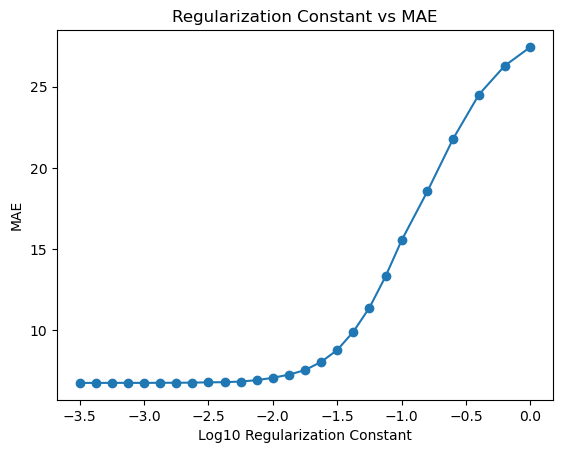

In [10]:
plt.plot(np.log10(regularization_const_list_new), list_base_new,'o-')
plt.xlabel("Log10 Regularization Constant")
plt.ylabel("MAE")
plt.title("Regularization Constant vs MAE")

Text(0.5, 1.0, 'Regularization Constant vs Objective function')

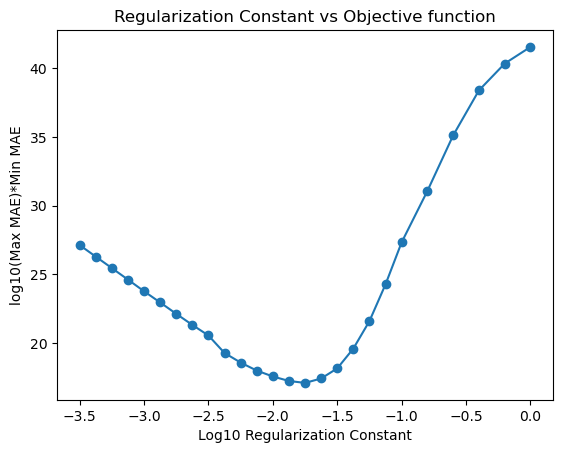

In [11]:
plt.plot(np.log10(regularization_const_list_new), np.log10(list_max_new)*list_base_new,'o-')
plt.xlabel("Log10 Regularization Constant")
plt.ylabel("log10(Max MAE)*Min MAE")
plt.title("Regularization Constant vs Objective function")

Text(0.5, 1.0, 'Inverse Regularization Constant')

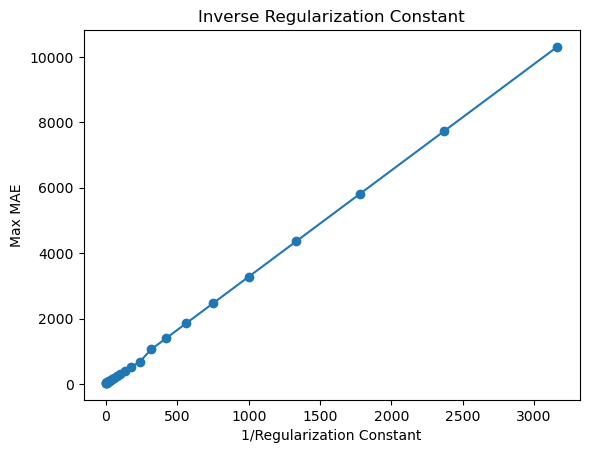

In [12]:
plt.plot(1/regularization_const_list_new, list_max_new,'o-')
plt.xlabel("1/Regularization Constant")
plt.ylabel("Max MAE")
plt.title("Inverse Regularization Constant")

/tmp/ipykernel_3063093/1734062004.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  regression_matrix = np.linalg.lstsq(domain.T, list_max_new)


Text(0.5, 1.0, 'Linear Regression of Max MAE')

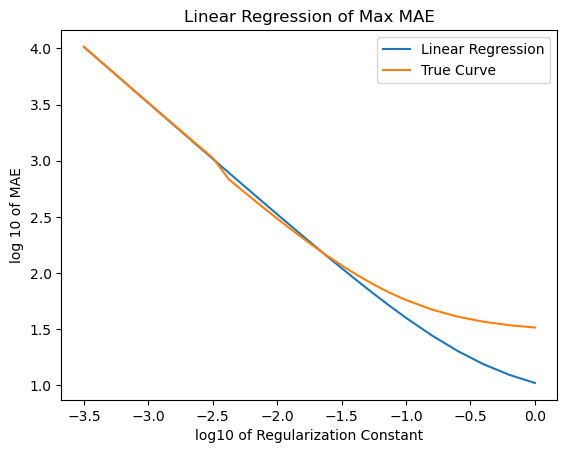

In [13]:
domain = np.vstack([1/regularization_const_list_new, np.ones(len(regularization_const_list_new))])
regression_matrix = np.linalg.lstsq(domain.T, list_max_new)
plt.plot(np.log10(regularization_const_list_new), np.log10(regression_matrix[0]@domain))
plt.plot(np.log10(regularization_const_list_new), np.log10(list_max_new))
plt.legend(["Linear Regression", "True Curve"])
plt.xlabel("log10 of Regularization Constant")
plt.ylabel("log 10 of MAE")
plt.title("Linear Regression of Max MAE")

In [45]:
def synthetic_tests(syn_function, regularization_const, confidence_level, number_of_points, domain_low, domain_high, polynomial_degree, model_name):

    #Getting networks
    model_base = tf.keras.models.load_model(model_name+"_base", compile=False)
    model_negative_loss = tf.keras.models.load_model(model_name+"_max", compile=False)
    model_quantile = tf.keras.models.load_model(model_name+"_quantile", compile=False)
    with open(model_name+"_bayes", 'rb') as f:
        reg = pickle.load(f)


    #Creating Dataset
    train_set_domain = np.random.uniform(domain_low, domain_high, number_of_points)

    train_set = syn_function(train_set_domain)+np.random.normal(0,1,number_of_points)
    calibration_set_domain = np.random.uniform(domain_low, domain_high, number_of_points)
    calibration_set = syn_function(calibration_set_domain)+np.random.normal(0,1,number_of_points)
    test_set_domain = np.random.uniform(domain_low, domain_high, number_of_points)
    test_set = syn_function(test_set_domain)+np.random.normal(0,1,number_of_points)

    #Feature expansion for baysein ridge regression
    train_set_domain_linear = np.ones([number_of_points,1])
    next_domain = train_set_domain
    train_set_domain_linear = np.append(train_set_domain_linear,np.expand_dims(next_domain,axis=1),axis=1)
    for i in range(polynomial_degree-2):
        next_domain=next_domain*train_set_domain
        train_set_domain_linear = np.append(train_set_domain_linear,np.expand_dims(next_domain,axis=1),axis=1)

    test_set_domain_linear = np.ones([number_of_points,1])
    next_domain = test_set_domain
    test_set_domain_linear = np.append(test_set_domain_linear,np.expand_dims(next_domain,axis=1),axis=1)
    for i in range(polynomial_degree-2):
        next_domain=next_domain*test_set_domain
        test_set_domain_linear = np.append(test_set_domain_linear,np.expand_dims(next_domain,axis=1),axis=1)

    
        


    #Getting Calibration predictions
    predictions_base = model_base.predict(calibration_set_domain, verbose=0)
    predictions_max = model_negative_loss.predict(calibration_set_domain, verbose=0)
    predictions_low, predictions_high = model_quantile.predict(calibration_set_domain, verbose=0)

    predictions_high = np.array(predictions_high)[:,0]
    predictions_low = np.array(predictions_low)[:,0]

    #Hoeffding Bound
    Max_l1 = np.mean(np.abs(predictions_max-calibration_set),axis=0)

    l1_norm = np.mean(np.abs(predictions_base-calibration_set),axis=0)

    Hoeffding_bound = np.array(l1_norm+Max_l1*np.sqrt((1/(2*number_of_points))*np.log(2/(1-confidence_level))))
    
    CP_index = np.ceil((number_of_points+1)*(confidence_level))


    high_indices = calibration_set > predictions_high
    low_indices = calibration_set < predictions_low
    middle_indices = np.logical_and(calibration_set <= predictions_high,calibration_set>= predictions_low)

    #calculating l1 distance for each of the three groups
    high_l1 = calibration_set[high_indices] - predictions_high[high_indices]
    low_l1 = predictions_low[low_indices] - calibration_set[low_indices]
    middle_l1 = np.maximum(calibration_set[middle_indices] - predictions_high[middle_indices], predictions_low[middle_indices] - calibration_set[middle_indices])

    #concat tf.tensors
    l1 = tf.concat([high_l1, low_l1, middle_l1], axis=0)

    #sorting, low to high
    l1 = tf.sort(l1)


    CP_bound = l1[int(CP_index)]

    predictions_base = model_base.predict(test_set_domain, verbose=0)
    predictions_base = np.array(predictions_base)[:,0]

    
    predictions_low, predictions_high = model_quantile.predict(test_set_domain, verbose=0)

    predictions_high = np.array(predictions_high)[:,0]
    predictions_low = np.array(predictions_low)[:,0]

    Hoeffing_upper = predictions_base + Hoeffding_bound
    Hoeffing_lower = predictions_base - Hoeffding_bound

    CP_high = predictions_high + CP_bound
    CP_low = predictions_low - CP_bound

    cov_matrix=reg.sigma_
    degrees = chi2.ppf(confidence_level, df=polynomial_degree)

    inner_term = np.matmul(cov_matrix,np.transpose(test_set_domain_linear))
    constant_term = degrees/np.sum(inner_term*np.transpose(test_set_domain_linear),axis=0)
    weights_offset = (constant_term)*(np.matmul(cov_matrix,np.transpose(test_set_domain_linear)))

    weights_max = np.expand_dims(reg.coef_,axis=1)*np.ones(weights_offset.shape)+weights_offset
    weights_min = np.expand_dims(reg.coef_,axis=1)*np.ones(weights_offset.shape)-weights_offset

    Bayes_min=np.sum((weights_min*np.transpose(test_set_domain_linear)),axis=0)
    average_values = np.sum((np.expand_dims(reg.coef_,axis=1)*np.ones(weights_offset.shape)*np.transpose(test_set_domain_linear)),axis=0)
    Bayes_max=np.sum((weights_max*np.transpose(test_set_domain_linear)),axis=0)


    #Can evaluate probalities directly given that the noise is Gaussian
    error_function = np.vectorize(erf)
    #Hoeffding
    Y_mean = syn_function(test_set_domain)
    
    Hoeffding_prob_correct = error_function(Hoeffing_upper,Y_mean,np.ones(number_of_points))-\
                            error_function(Hoeffing_lower,Y_mean,np.ones(number_of_points))
    #CP
    CP_prob_correct = error_function(CP_high,Y_mean,np.ones(number_of_points))-\
                            error_function(CP_low,Y_mean,np.ones(number_of_points))
    
    Bayes_prob_correct= error_function(Bayes_max,Y_mean,np.ones(number_of_points))-\
                            error_function(Bayes_min,Y_mean,np.ones(number_of_points))
    
    True_bound_upper = Y_mean + 2**(1/2)*erfinv(.5+confidence_level/2)
    True_bound_lower = Y_mean + 2**(1/2)*erfinv(-(.5+confidence_level/2))

    return test_set_domain, [True_bound_lower,True_bound_upper], [CP_low, CP_high], [Hoeffing_lower,predictions_base, Hoeffing_upper], [Bayes_min, reg.predict(test_set_domain_linear), Bayes_max]

In [46]:
test_set_domain, True_Bounds, CP, Hoeff, Bayes =synthetic_tests(synthetic_function1, regularization_const, .9, 10000, -10, 10, 17, synthetic_model_name[0])

In [47]:
sample_data = np.random.choice(len(test_set_domain), 1000, replace=False)
sorted_list_indices = np.argsort(test_set_domain[sample_data])
mean_set = synthetic_function1(test_set_domain[sample_data])

Text(0.5, 1.0, 'Periodic Function Results')

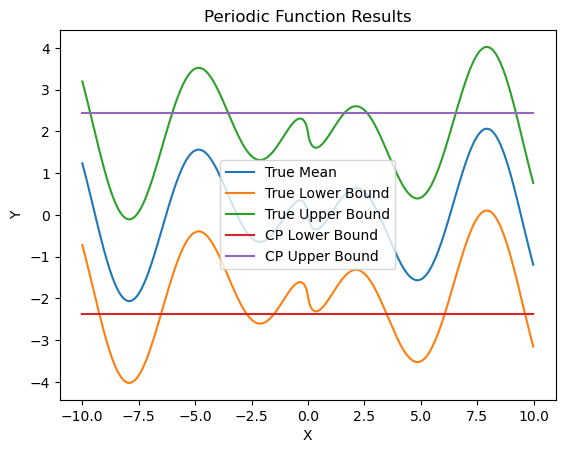

In [48]:
plt.plot((test_set_domain[sample_data])[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], ((True_Bounds[0])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], ((True_Bounds[1])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], (np.array(CP[0])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], (np.array(CP[1])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", "CP Lower Bound", "CP Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")

In [ ]:
plt.plot((test_set_domain[sample_data])[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], ((True_Bounds[0])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], ((True_Bounds[1])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], (np.array([0])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], (np.array([1])[sample_data])[sorted_list_indices])
plt.plot((test_set_domain[sample_data])[sorted_list_indices], (np.array([2])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", " Lower Bound", " Mean", " Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")

In [ ]:
plt.plot(test_set_domain[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", " Lower Bound", " Mean", " Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")

In [ ]:
plt.plot(test_set_domain[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", " Lower Bound", " Mean", " Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")

In [ ]:
plt.plot(test_set_domain[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", " Lower Bound", " Mean", " Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")

In [ ]:
plt.plot(test_set_domain[sorted_list_indices], mean_set[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([1])[sample_data])[sorted_list_indices])
plt.plot(test_set_domain[sorted_list_indices], (([0])[sample_data])[sorted_list_indices])
plt.legend(["True Mean", "True Lower Bound", "True Upper Bound", " Lower Bound", " Mean", " Upper Bound"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Periodic Function Results")